In [1]:
from tools import rv_from_cdf, N, U
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, geom
from tqdm import trange, tqdm
import mpmath as mp
plt.style.use('seaborn-whitegrid')

Розглядаємо процес страхового ризику $U$, який згідно з моделлю Крамера-Лундберга має вигляд
$$
    U(t) = u_0 + ct - \sum_{i=1}^{N(t)} X_i, \; t \geq 0
$$
де $u_0 = U(0)$ – початковий капітал, $c$ – сумарна величина страхових внесків за одиницю часу,
$N$ – однорідний процесс Пуассона з інтенсивністю $\lambda > 0$, стрибки якого відбуваються в моменти настання страхових подій,
$X_i, i \in \N$ – незалежні між собою та від $N$ однаково розподілені м.н. невід'ємні страхові виплати. Функція розподілу страхових виплат: 
$$
    F(x) = \begin{cases}
        0, & x < 0 \\
        \frac{1}{2} \left(1 - \cos x\right), & 0 \leq x < \pi \\
        1, & x \geq \pi
    \end{cases}
$$

In [2]:
X = rv_from_cdf([0, np.pi], cdf=lambda x: (1 - np.cos(x))/2, inv_cdf=lambda y: np.arccos(1-2*y), mean=np.pi/2)

variant = 2
if variant == 1:
    u0, lmb = 1, 1
    c = 2 * lmb * X.mean()
    c_text = '\pi'
elif variant == 2:
    u0, lmb = 10, 5
    c = 1.05 * lmb * X.mean()
    c_text = '2.625 \pi'

На часовому проміжку $[0, 10]$ змоделювати та побудувати на спільному рисунку графіки $5$ траєкторій процесу $U$.

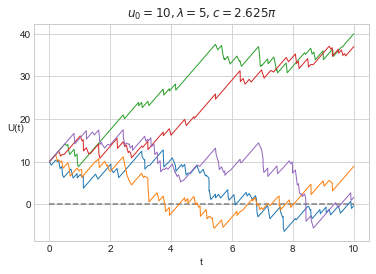

In [3]:
for i in range(5):
    T, time, u = U(10, u0, c, lmb, X)
    plt.plot(time, u, linewidth=1)
plt.hlines(0, time.min(), time.max(), linestyles='--', color='gray')
plt.title(f'$u_0 = {u0}, \lambda = {lmb}, c = {c_text}$')
plt.xlabel('t')
plt.ylabel('U(t)', rotation=0)
plt.show()

Межі довірчого інтервалу для ймовірності появи події для великої кількості випробувань визначаються з 
$$
    p_{1, 2} = p^* \pm t_{\gamma} \sqrt{\frac{p^* \left(1 - p^*\right)}{n}}
$$
де $t_{\gamma}$ – значення оберненої функції Лапласа в точці $\gamma / 2$ для рівня надійності $\gamma$.

In [4]:
def conf_interval(p, n, conf=0.95):
    t = norm.ppf(conf/2 + 0.5)
    delta = t * np.sqrt(p * (1-p) / n)
    return delta, (p - delta, p + delta)

Оцінити ймовірність банкрутства за допомогою грубого методу Монте-Карло: для цього на проміжку $[0, 1000]$
змоделювати 1000 траєкторій процесу $U$ й обчислити частку тих, що банкрутують протягом цього проміжку.

In [5]:
ruin_count = 0
trials = 1000
for i in trange(trials):
    T, time, u = U(1000, u0, c, lmb, X)
    if np.any(u < 0):
        ruin_count += 1

print(ruin_count / trials)
print(conf_interval(ruin_count / trials, trials))

100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]

0.569
(0.030693248764642148, (0.5383067512353578, 0.5996932487646421))


Оцінити ймовірність банкрутства за допомогою більш точного методу Монте-Карло: для цього спочатку записати функцію розподілу
модифікованої величини $\tilde{X}$, а потім змоделювати геометрично розподілену кількість незалежних копій цієї величини.
Функція розподілу $\tilde{X}$ має вигляд
$$
    F_{\tilde{X}}(x) = \frac{1}{\mathbb{E} X} \int_0^x \left(1 - F_X(t)\right) dt = \begin{cases}
        0, & x < 0 \\
        \frac{2}{\pi} \int_0^x \frac{1}{2}\left(1 + \cos t\right) dt = \frac{1}{\pi} \left(x + \sin x\right), & 0 \leq x < \pi \\
        \frac{2}{\pi} \int_0^{\pi} \frac{1}{2}\left(1 + \cos t\right) dt = 1, & x \geq \pi 
    \end{cases}
$$

In [6]:
X_tilde = rv_from_cdf([0, np.pi], cdf=lambda x: (x + np.sin(x))/np.pi, pdf=lambda x: (1 + np.cos(x))/np.pi)
G = geom(p=1 - lmb * X.mean() / c, loc=-1)

ruin_count = 0
trials = 1000
for g in tqdm(G.rvs(trials)):
    x_tilde = X_tilde.rvs(g)
    ruin_count += int(x_tilde.sum() > u0)
    
print(ruin_count / trials)
print(conf_interval(ruin_count / trials, trials))

100%|██████████| 1000/1000 [00:04<00:00, 232.19it/s]

0.591
(0.030472177222498616, (0.5605278227775013, 0.6214721772224986))


Оцінити ймовірність банкрутства за допомогою чисельного знаходження оберненого перетворення Лапласа. $\psi(u)$ – ймовірність банкрутства при початковому капіталі $u$, $\varphi(u) = 1 - \psi(u)$ задовольняє інтегральне рівняння 
$$
    \varphi(u) = \varphi(0) + \frac{\lambda}{c} \int_0^u \varphi(u - y) \left(1 - F(y)\right) dy, \; u \geq 0
$$
Після застосування перетворення Лапласа до обох частин отримаємо
$$
\Phi(p) = 
    \frac{1 - \frac{\lambda \mu}{c}}{
        p \left(1 -  \frac{\lambda}{c} \cdot \mathcal{L}\left\{1 - F(y)\right\}(p) \right)
    } = \left(1 - \frac{\lambda \mu}{c}\right) \cdot
    \frac{p^2 + 1}{
        p^3 + p - \frac{\lambda}{2c} \cdot
        \left(1 + 2p^2 - e^{-\pi p}\right)
    }
$$

psi(u0) = 0.575759530142741


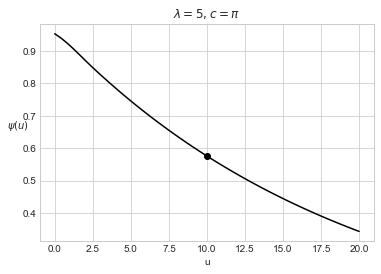

In [7]:
F_p = lambda p: (1 - lmb * X.mean() / c) * (p**2 + 1) / (p**3 + p - (lmb / (2*c)) * (1 + 2*p**2 - mp.exp(-mp.pi * p)))
f_t = lambda t: mp.invertlaplace(F_p, t, method='dehoog') if t > 0 else (1 - lmb * X.mean() / c)
psi_t = lambda t: 1 - f_t(t)

print('psi(u0) =', psi_t(u0))

t_domain = np.linspace(0, 20)
plt.plot(t_domain, [float(psi_t(t)) for t in t_domain], color='black')
plt.scatter(u0, float(psi_t(u0)), color='black')
plt.title(f'$\lambda = {lmb}, c = \pi$')
plt.xlabel('u')
plt.ylabel('$\psi(u)$', rotation=0)
plt.savefig('latex/pics/psi_2.png', dpi=300, bbox_inches='tight')
plt.show()